## 日経平均予測
### 翌営業日の日経平均終値に対する単純騰落予測（上がるか／下がるか）、
### および４パターン増減予測（①1%以上 ②0%以上、1%未満　 ③-1%以上、0%未満　 ④-1%超）を行う。

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import time

from __future__ import print_function
from keras.layers.core import Activation
from keras.layers.core import Dense
from keras.layers.core import Dropout
from keras.models import Sequential
from keras.utils import np_utils

from keras.layers.recurrent import LSTM
from keras.callbacks import EarlyStopping
from keras.initializers import glorot_uniform
from keras.initializers import orthogonal
from keras.initializers import TruncatedNormal
from keras import optimizers
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

from keras.utils import plot_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

C:\Users\yt690\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### CSVファイル読み込み

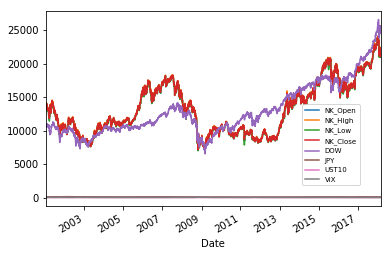

,NK_Open,NK_High,NK_Low,NK_Close,DOW,JPY,UST10,VIX
count,4212.000000,4212.000000,4212.000000,4212.000000,4212.000000,4212.000000,4212.000000,4212.000000
mean,13262.233787,13346.654815,13170.434124,13258.716387,12991.540825,106.201968,3.366668,19.624644
std,3830.559487,3840.189231,3818.034989,3830.598834,3878.067970,14.182328,1.124416,8.903100
min,7059.770000,7100.770000,6994.900000,7054.980000,6547.049805,75.820000,1.358000,9.190000
25%,10008.805000,10058.827500,9924.372500,9999.692500,10296.582275,97.367500,2.321000,13.400000
50%,12203.390000,12350.825000,12131.185000,12241.785000,11810.310060,109.190000,3.460000,17.140000
75%,16334.582500,16417.162500,16214.240000,16313.537500,15741.292237,117.810000,4.340625,23.061250
max,24078.930000,24129.340000,23917.140000,24124.150000,26616.710940,134.770000,5.520000,80.860000


In [2]:
# 学習データの読み込み
df = pd.read_csv('mktdat.csv',encoding='utf-8',index_col='Date', parse_dates=[0])

#データ確認
df.head() 
df.plot()
plt.legend(bbox_to_anchor=(1, 0), loc='lower right', borderaxespad=3, fontsize=7)
plt.show()
df.describe()

### データ加工

In [3]:
#増減率（100＊log（前日比））を計算し、新たな列を追加

for i in range(len(df.columns)):
    use_col = df.columns[i]
    df[use_col] =  100*np.log(df[use_col]/df[use_col].shift())
            
#前日比をとったので、先頭行にNaNが含まれるため、先頭行を削除
df=df.dropna(how='any')

In [4]:
df.describe()

,NK_Open,NK_High,NK_Low,NK_Close,DOW,JPY,UST10,VIX
count,4211.000000,4211.000000,4211.000000,4211.000000,4211.000000,4211.000000,4211.000000,4211.000000
mean,0.010328,0.010260,0.010326,0.010138,0.019576,-0.002059,-0.013235,-0.009132
std,1.383950,1.226334,1.442916,1.523779,1.125796,0.663355,2.092684,6.876165
min,-10.318807,-7.332852,-19.129023,-12.111026,-8.200514,-3.772221,-16.835190,-49.640545
25%,-0.739139,-0.642710,-0.684994,-0.728694,-0.432454,-0.353331,-1.146035,-3.773617
50%,0.025382,0.008113,0.068890,0.042793,0.049782,0.008419,-0.080402,-0.346421
75%,0.812230,0.710528,0.814304,0.826839,0.522466,0.361572,1.073416,3.208465
max,11.052204,9.506217,11.065648,13.234585,10.325919,5.215666,18.636851,76.824501


In [5]:
#日経平均終値の増減率を4パターンに分類
df['NK_Close_P1'] = df['NK_Close'] >=1  
df['NK_Close_P2'] =  (0 == df['NK_Close']) | (0 < df['NK_Close']) & (df['NK_Close']<1)
df['NK_Close_P3'] =  (-1<= df['NK_Close']) & (df['NK_Close']<0)
df['NK_Close_P4'] = df['NK_Close']<-1

df['NK_Close_P1'] = df['NK_Close_P1'].astype(np.int)
df['NK_Close_P2'] = df['NK_Close_P2'].astype(np.int)
df['NK_Close_P3'] = df['NK_Close_P3'].astype(np.int)
df['NK_Close_P4'] = df['NK_Close_P4'].astype(np.int)
df.head()

,NK_Open,NK_High,NK_Low,NK_Close,DOW,JPY,UST10,VIX,NK_Close_P1,NK_Close_P2,NK_Close_P3,NK_Close_P4
Date,,,,,,,,,,,,
2001-01-09,-0.220904,-1.547796,-1.946926,-1.871362,-2.321375,0.740362,-2.207152,6.112614,0,0,0,1
2001-01-10,-1.022405,-1.022405,-0.833053,-1.315398,-0.842593,0.205638,1.270050,-2.400398,0,0,0,1
2001-01-11,-1.184566,-1.158365,-1.702457,-1.739042,0.299570,-0.291445,2.101167,-4.344542,0,0,0,1
2001-01-12,-1.401035,0.114101,0.928258,1.104920,0.049782,1.067337,0.215538,-3.841507,1,0,0,0
2001-01-15,1.528920,0.899897,1.463771,1.180398,-0.796505,0.618096,2.817631,-4.886772,1,0,0,0


In [6]:
# 学習データ
x_data = np.array(df.iloc[:,0:(len(df.columns)-4)].astype(np.float))

# ラベルデータ（増減率４パターン）
y_data = np.array(df.iloc[:,(len(df.columns)-4):].astype(np.float)) 

In [7]:
maxlen = 80              # 入力系列数
n_in = x_data.shape[1]   # 学習データ（＝入力）の列数
print("n_in:",n_in)
n_out = y_data.shape[1]  # ラベルデータ（=出力）の列数
print("n_out:",n_out)
len_seq = x_data.shape[0] - maxlen
print("x_data.shape[0]:",x_data.shape[0])
print("len_seq:",len_seq)

data = []
target = []
for i in range(0, len_seq):
  data.append(x_data[i:i+maxlen, :]) #80個ずつずらして取得
  target.append(y_data[i+maxlen, :])#80個目から取得

print("len(data):",len(data))
x = np.array(data).reshape(len(data), maxlen, n_in)
y = np.array(target).reshape(len(data), n_out)

print(x.shape, y.shape)

n_in: 8
n_out: 4
x_data.shape[0]: 4211
len_seq: 4131
len(data): 4131
(4131, 80, 8) (4131, 4)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 80)                28480     
_________________________________________________________________
dropout_1 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 324       
_________________________________________________________________
activation_1 (Activation)    (None, 4)                 0         
Total params: 28,804
Trainable params: 28,804
Non-trainable params: 0
_________________________________________________________________


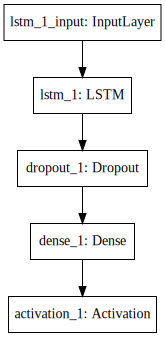

In [8]:
n_hidden = 80     # 出力次元
epochs = 100      # エポック数
batch_size = 10   # ミニバッチサイズ

# ネットワークモデル構築
model = Sequential()
model.add(LSTM(n_hidden, batch_input_shape = (None, maxlen, n_in),kernel_initializer = glorot_uniform(seed=1234), recurrent_initializer = orthogonal(gain=1.0, seed=1234), dropout = 0.5, recurrent_dropout = 0.5))
model.add(Dropout(0.5))
model.add(Dense(n_out,kernel_initializer = glorot_uniform(seed=1234)))
model.add(Activation("softmax"))
model.compile(loss="categorical_crossentropy", optimizer = "RMSprop", metrics = ['accuracy'])

# モデルのサマリを表示
model.summary()
plot_model(model, to_file='model.png')
SVG(model_to_dot(model).create(prog='dot', format='svg'))

Train on 3345 samples, validate on 372 samples
Epoch 1/100
3345/3345 [==============================] - 21s - loss: 1.3893 - acc: 0.2921 - val_loss: 1.3539 - val_acc: 0.2984
Epoch 2/100
3345/3345 [==============================] - 20s - loss: 1.3683 - acc: 0.3058 - val_loss: 1.3538 - val_acc: 0.2984
Epoch 3/100
3345/3345 [==============================] - 20s - loss: 1.3643 - acc: 0.3079 - val_loss: 1.3411 - val_acc: 0.3306
Epoch 4/100
3345/3345 [==============================] - 20s - loss: 1.3589 - acc: 0.3175 - val_loss: 1.3374 - val_acc: 0.3575
Epoch 5/100
3345/3345 [==============================] - 20s - loss: 1.3544 - acc: 0.3016 - val_loss: 1.3452 - val_acc: 0.3468
Epoch 6/100
3345/3345 [==============================] - 20s - loss: 1.3503 - acc: 0.3097 - val_loss: 1.3448 - val_acc: 0.3118
Epoch 7/100
3345/3345 [==============================] - 20s - loss: 1.3523 - acc: 0.3145 - val_loss: 1.3405 - val_acc: 0.2876
Epoch 8/100
3345/3345 [==============================] - 20s - l

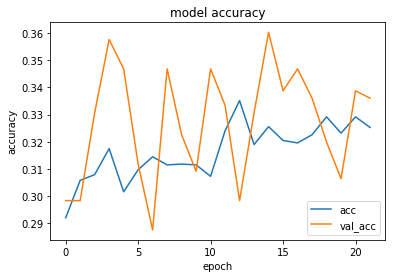

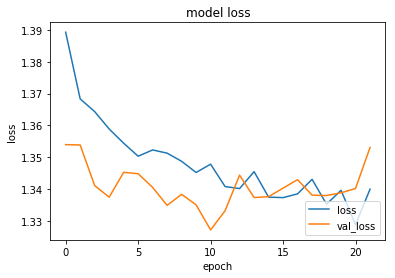

Wall time: 8min 12s


In [9]:
%%time

#データを学習用とテスト用に分割 
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.1, random_state=1234)         

# 学習
early_stopping = EarlyStopping(patience=10, verbose=1)
history = model.fit(x_train, y_train, batch_size = batch_size, epochs = epochs, verbose = 1,shuffle = True, callbacks = [early_stopping], validation_split = 0.1)

# 精度の履歴をプロット
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['acc', 'val_acc'], loc='lower right')
plt.show()

# 損失の履歴をプロット
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'], loc='lower right')
plt.show()

In [10]:
#テスト
score = model.evaluate(x_test, y_test, batch_size = batch_size, verbose = 1)
print("score:", score)

#識別率（騰落４分類）
y_pred = model.predict(x_test)
correct = 0
semi_correct = 0
for i in range(len(y_pred)):
  pred = np.argmax(y_pred[i,:])
  tar = np.argmax(y_test[i,:])
  if pred == tar :
    correct += 1
  else :
    if pred+tar == 1 or pred+tar == 5 :
      semi_correct += 1

print("識別率（騰落４分類）: %6.5f" % (1.0 * correct / len(y_pred)))
print("識別率（騰落）: %6.5f" % (1.0 * (correct+semi_correct) / len(y_pred)))

380/414 [==========================>...] - ETA: 0sscore: [1.3543526141539863, 0.3091787519518304]
識別率（騰落４分類）: 0.30918
識別率（騰落）: 0.51208
